In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_absolute_percentage_error

# Read the data
df = pd.read_csv("../Data/merged_cleaned.csv", delimiter=",")

# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("[MWh]", "")

# Drop 'date' column as it's redundant
df = df.drop('date', axis=1)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# One-hot encode 'Holiday' and 'day_name' columns
df = pd.get_dummies(df, columns=['Holiday', 'day_name'], drop_first=True)

# Fill missing values with forward fill
df = df.fillna(method='ffill')

# # Add Last Year Value (same day, last year)
# df['Last_Year'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(365 * 24)

# # Add Last Week Value (same day, last week)
# df['Last_Week'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(168)

C:\Users\TimPr\AppData\Local\Temp\ipykernel_12192\618105036.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [20]:
df = df.dropna()

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Date']))

# Add back the scaled data to the DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled['Date'] = df['Date']

# Split the data into train, validation, and test
train = df_scaled[df_scaled['Date'] < '2023-10-30']
test = df_scaled[df_scaled['Date'] >= '2023-10-30']

# Optional: Split the train set into training and validation
val = train.tail(len(train)//10)
train = train.head(len(train) - len(val))


In [21]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch import nn

# Create dataset class for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=48):
        self.data = data
        self.window_size = window_size
        self.features = data.drop(columns=['Date']).values
        self.target = data['Gesamt_(Netzlast)__Berechnete_Auflösungen'].values

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.window_size]
        y = self.target[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Set window size for LSTM (48 hours = 2 days of data)
window_size = 168

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train, window_size)
val_dataset = TimeSeriesDataset(val, window_size)
test_dataset = TimeSeriesDataset(test, window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [22]:
# Check the size of the dataframes
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

# Check the min and max dates in each dataframe
print(f"Min and Max dates in Training set: {train['Date'].min()}, {train['Date'].max()}")
print(f"Min and Max dates in Validation set: {val['Date'].min()}, {val['Date'].max()}")
print(f"Min and Max dates in Test set: {test['Date'].min()}, {test['Date'].max()}")


Training set size: 39425
Validation set size: 4380
Test set size: 8814
Min and Max dates in Training set: 2018-11-01 01:00:00, 2023-04-30 18:00:00
Min and Max dates in Validation set: 2023-04-30 19:00:00, 2023-10-29 23:00:00
Min and Max dates in Test set: 2023-10-30 00:00:00, 2024-10-30 23:00:00


In [23]:
def check_for_nas(dataset, name):
    contains_nan = False
    for i in range(len(dataset)):
        x, y = dataset[i]
        if np.isnan(x).any() or np.isnan(y).any():
            contains_nan = True
            print(f"NaN found in {name} at index {i}")
            break
    if not contains_nan:
        print(f"No NaNs found in {name} dataset.")

# Check each dataset
check_for_nas(train_dataset, "Train")
check_for_nas(val_dataset, "Validation")
check_for_nas(test_dataset, "Test")


C:\Users\TimPr\AppData\Local\Temp\ipykernel_12192\2899205153.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if np.isnan(x).any() or np.isnan(y).any():


No NaNs found in Train dataset.
No NaNs found in Validation dataset.
No NaNs found in Test dataset.


In [31]:
import torch
import pytorch_lightning as pl
from torch import nn

class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        # Multi-layer LSTM with dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Batch normalization for LSTM output
        self.batch_norm = nn.BatchNorm1d(hidden_layer_size)

        # Additional fully connected layer
        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size // 2)
        self.relu = nn.ReLU()

        # Final output layer
        self.fc2 = nn.Linear(hidden_layer_size // 2, output_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last time step
        lstm_out = self.batch_norm(lstm_out)  # Apply batch normalization
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        lstm_out = self.fc1(lstm_out)  # First fully connected layer
        lstm_out = self.relu(lstm_out)  # Apply ReLU activation
        lstm_out = self.dropout(lstm_out)  # Apply dropout again
        return self.fc2(lstm_out)  # Final output layer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00003)



In [29]:
torch.set_float32_matmul_precision('high')


In [37]:
import torch
import numpy as np
import optuna
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


In [38]:
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_layer_size)
        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size // 2, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc1(lstm_out)
        lstm_out = self.relu(lstm_out)
        lstm_out = self.dropout(lstm_out)
        return self.fc2(lstm_out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        # Calculate MSE Loss
        mse_loss = nn.MSELoss()(y_hat.squeeze(), y)
        
        # Calculate MAPE
        y_true = y.detach().cpu().numpy()
        y_pred = y_hat.squeeze().detach().cpu().numpy()
        
        # Avoid division by zero
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        
        # Log both metrics
        self.log("val_loss", mse_loss, prog_bar=True)
        self.log("val_mape", mape, prog_bar=True)
        
        return {"val_loss": mse_loss, "val_mape": mape}

    def on_validation_epoch_end(self):
        outputs = self.trainer.callback_metrics
        avg_mape = outputs.get("val_mape")
        avg_loss = outputs.get("val_loss")

        if avg_mape is not None and avg_loss is not None:
            print(f"\nValidation MAPE: {avg_mape:.2f}%")
            print(f"Validation MSE: {avg_loss:.6f}")

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00003)

def objective(trial):
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 64, 256, step=64)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    
    model = LSTMModel(input_size=train_dataset.features.shape[1], 
                      hidden_layer_size=hidden_layer_size, 
                      dropout=dropout)
    
    logger = TensorBoardLogger("tb_logs", name="lstm_model")
    
    checkpoint_callback = ModelCheckpoint(
        monitor="val_mape",  # Changed to monitor MAPE
        dirpath="checkpoints",
        filename="best_model-{epoch:02d}-{val_mape:.2f}",
        save_top_k=1,
        mode="min",
    )
    
    early_stopping_callback = EarlyStopping(
        monitor="val_mape",  # Changed to monitor MAPE
        patience=10,
        mode="min",
        verbose=True,
    )
    
    trainer = pl.Trainer(
        max_epochs=100,
        devices=1,
        accelerator="gpu",
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping_callback],
    )
    
    trainer.fit(model, train_loader, val_loader)
    
    # Return the validation MAPE as the objective to minimize
    return trainer.callback_metrics["val_mape"].item()

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and their performance
print("\nOptimization Results:")
print("Best Hyperparameters:", study.best_params)
print(f"Best Validation MAPE: {study.best_value:.2f}%")

# Train final model with best parameters
best_model = LSTMModel(
    input_size=train_dataset.features.shape[1],
    hidden_layer_size=study.best_params["hidden_layer_size"],
    dropout=study.best_params["dropout"]
)

final_trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator="gpu",
    logger=TensorBoardLogger("tb_logs", name="final_model"),
    callbacks=[
        ModelCheckpoint(monitor="val_mape", mode="min"),
        EarlyStopping(monitor="val_mape", patience=10, mode="min")
    ]
)

final_trainer.fit(best_model, train_loader, val_loader)

[I 2025-01-20 16:52:08,614] A new study created in memory with name: no-name-1bcee9df-707e-4908-b79c-f324d58d351b
C:\Users\TimPr\AppData\Local\Temp\ipykernel_12192\1310660092.py:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\TimPr\allcode\energy-timeseries-project\3_Model\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 777 K  | tra

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.07it/s]
Validation MAPE: 91.86%
Validation MSE: 0.197253
                                                                           

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0:  46%|████▌     | 280/614 [00:18<00:21, 15.23it/s, v_num=12, train_loss=0.103] 


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-01-20 16:52:27,665] Trial 0 failed with parameters: {'hidden_layer_size': 192, 'dropout': 0.35433813951749915, 'learning_rate': 3.2193001100850356e-05} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
  File "c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 575, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py", line 982, in _run
    results = self._run_stage()
  File "c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py", 

NameError: name 'exit' is not defined

In [30]:
# import optuna
# import pytorch_lightning as pl
# import torch
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger
# from torch.utils.data import DataLoader
# from torch import nn

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameters to search over
#     hidden_layer_size = trial.suggest_int("hidden_layer_size", 64, 256, step=64)  # Random search between 64 and 256
#     dropout = trial.suggest_float("dropout", 0.2, 0.5)  # Dropout between 0.2 and 0.5
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  # Learning rate between 1e-5 and 1e-2
    
#     # Define the model with the sampled hyperparameters
#     model = LSTMModel(input_size=train_dataset.features.shape[1], 
#                       hidden_layer_size=hidden_layer_size, 
#                       dropout=dropout)
    
#     # Initialize the TensorBoard logger
#     logger = TensorBoardLogger("tb_logs", name="lstm_model")
    
#     # Define the callbacks
#     checkpoint_callback = ModelCheckpoint(
#         monitor="val_loss",
#         dirpath="checkpoints",
#         filename="best_model-{epoch:02d}-{val_loss:.4f}",
#         save_top_k=1,
#         mode="min",
#     )
    
#     early_stopping_callback = EarlyStopping(
#         monitor="val_loss",
#         patience=10,
#         mode="min",
#         verbose=True,
#     )
    
#     # Create the trainer
#     trainer = pl.Trainer(
#         max_epochs=100,
#         devices=1,
#         accelerator="gpu",
#         logger=logger,
#         callbacks=[checkpoint_callback, early_stopping_callback],  # Add callbacks
#     )
    
#     # Load your data (make sure this is set up before fitting)
#     # For example, assuming you have train_loader and val_loader:
#     trainer.fit(model, train_loader, val_loader)
    
#     # Return the validation loss as the objective to minimize
#     return trainer.callback_metrics["val_loss"].item()

# # Create a study for hyperparameter optimization
# study = optuna.create_study(direction="minimize")

# # Start the optimization process
# study.optimize(objective, n_trials=10)  # Try 10 different combinations

# # Print the best hyperparameters
# print("Best Hyperparameters: ", study.best_params)

# Best Hyperparameters:  {'hidden_layer_size': 128, 'dropout': 0.2178453460599993, 'learning_rate': 2.9307600573498003e-05}, Time 54min

[I 2025-01-20 12:56:07,816] A new study created in memory with name: no-name-4f0eb671-e1da-40fa-aee7-72ce8c6e79f5
C:\Users\TimPr\AppData\Local\Temp\ipykernel_12192\175115929.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  # Learning rate between 1e-5 and 1e-2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 354 K  | train
1 | batch_norm | BatchNorm1d | 256    | train
2 | fc1        | Linear      | 8.3 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 65     | train
5 | dropout    |

Epoch 0: 100%|██████████| 614/614 [00:06<00:00, 96.69it/s, v_num=2, val_loss=0.00233]

Metric val_loss improved. New best score: 0.002


Epoch 1: 100%|██████████| 614/614 [00:04<00:00, 125.97it/s, v_num=2, val_loss=0.00191]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:04<00:00, 125.45it/s, v_num=2, val_loss=0.00185]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 3: 100%|██████████| 614/614 [00:05<00:00, 121.55it/s, v_num=2, val_loss=0.00106]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 614/614 [00:04<00:00, 131.78it/s, v_num=2, val_loss=0.000873]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 614/614 [00:04<00:00, 122.97it/s, v_num=2, val_loss=0.000613]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 614/614 [00:05<00:00, 120.58it/s, v_num=2, val_loss=0.000601]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 614/614 [00:04<00:00, 126.39it/s, v_num=2, val_loss=0.000598]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 14: 100%|██████████| 614/614 [00:04<00:00, 127.16it/s, v_num=2, val_loss=0.000511]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 614/614 [00:04<00:00, 123.45it/s, v_num=2, val_loss=0.000489]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 614/614 [00:04<00:00, 132.45it/s, v_num=2, val_loss=0.000362]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 614/614 [00:04<00:00, 126.64it/s, v_num=2, val_loss=0.000338]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 614/614 [00:04<00:00, 129.12it/s, v_num=2, val_loss=0.000328]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 614/614 [00:04<00:00, 124.34it/s, v_num=2, val_loss=0.00027] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 614/614 [00:04<00:00, 128.55it/s, v_num=2, val_loss=0.000229]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 614/614 [00:04<00:00, 125.88it/s, v_num=2, val_loss=0.000278]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 39: 100%|██████████| 614/614 [00:04<00:00, 125.86it/s, v_num=2, val_loss=0.000278]


[I 2025-01-20 12:59:23,925] Trial 0 finished with value: 0.0002779727801680565 and parameters: {'hidden_layer_size': 128, 'dropout': 0.2178453460599993, 'learning_rate': 2.9307600573498003e-05}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 1.4 M  | train
1 | batch_norm | BatchNorm1d | 512    | train
2 | fc1        | Linear      | 32.9 K | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 129    | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.590     Total estimated model params size (MB)
6         Modules in train mode
0      

Epoch 0: 100%|██████████| 614/614 [00:17<00:00, 35.88it/s, v_num=3, val_loss=0.00671]

Metric val_loss improved. New best score: 0.007


Epoch 1: 100%|██████████| 614/614 [00:17<00:00, 35.56it/s, v_num=3, val_loss=0.00152]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:17<00:00, 35.70it/s, v_num=3, val_loss=0.00136]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 4: 100%|██████████| 614/614 [00:17<00:00, 35.49it/s, v_num=3, val_loss=0.00127]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 7: 100%|██████████| 614/614 [00:17<00:00, 36.06it/s, v_num=3, val_loss=0.00118]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 614/614 [00:16<00:00, 36.15it/s, v_num=3, val_loss=0.000481]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 614/614 [00:17<00:00, 35.72it/s, v_num=3, val_loss=0.000403]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 614/614 [00:17<00:00, 35.72it/s, v_num=3, val_loss=0.000373]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 614/614 [00:17<00:00, 35.88it/s, v_num=3, val_loss=0.000315]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 614/614 [00:17<00:00, 35.65it/s, v_num=3, val_loss=0.000284]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 38: 100%|██████████| 614/614 [00:17<00:00, 35.55it/s, v_num=3, val_loss=0.000281]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 614/614 [00:17<00:00, 35.42it/s, v_num=3, val_loss=0.000248]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 614/614 [00:17<00:00, 35.39it/s, v_num=3, val_loss=0.000234]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 614/614 [00:17<00:00, 34.88it/s, v_num=3, val_loss=0.000225]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 55: 100%|██████████| 614/614 [00:17<00:00, 35.91it/s, v_num=3, val_loss=0.000278]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 55: 100%|██████████| 614/614 [00:17<00:00, 35.91it/s, v_num=3, val_loss=0.000278]


[I 2025-01-20 13:15:28,411] Trial 1 finished with value: 0.0002779935020953417 and parameters: {'hidden_layer_size': 256, 'dropout': 0.30596989393312907, 'learning_rate': 0.0001582448027184268}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 777 K  | train
1 | batch_norm | BatchNorm1d | 384    | train
2 | fc1        | Linear      | 18.5 K | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 97     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
796 K     Trainable params
0         Non-trainable params
796 K     Total params
3.185     Total estimated model params size (MB)
6         Modules in train mode
0      

Epoch 0: 100%|██████████| 614/614 [00:18<00:00, 33.31it/s, v_num=4, val_loss=0.00836]

Metric val_loss improved. New best score: 0.008


Epoch 1: 100%|██████████| 614/614 [00:16<00:00, 36.26it/s, v_num=4, val_loss=0.00215]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:16<00:00, 36.91it/s, v_num=4, val_loss=0.00182]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 4: 100%|██████████| 614/614 [00:16<00:00, 37.10it/s, v_num=4, val_loss=0.00117]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 614/614 [00:16<00:00, 36.85it/s, v_num=4, val_loss=0.000707]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 614/614 [00:16<00:00, 37.42it/s, v_num=4, val_loss=0.000576]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 614/614 [00:17<00:00, 35.89it/s, v_num=4, val_loss=0.000352]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 614/614 [00:16<00:00, 36.82it/s, v_num=4, val_loss=0.000273]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 614/614 [00:16<00:00, 36.23it/s, v_num=4, val_loss=0.000408]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 614/614 [00:16<00:00, 36.23it/s, v_num=4, val_loss=0.000408]

[I 2025-01-20 13:23:33,732] Trial 2 finished with value: 0.0004078107012901455 and parameters: {'hidden_layer_size': 192, 'dropout': 0.2643571947561453, 'learning_rate': 0.0002761345977681601}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 777 K  | train
1 | batch_norm | BatchNorm1d | 384    | train
2 | fc1        | Linear      | 18.5 K | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 97     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
796 K     Trainable params
0         Non-trainable params
796 K     Total params
3.185     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:17<00:00, 35.33it/s, v_num=5, val_loss=0.00511]

Metric val_loss improved. New best score: 0.005


Epoch 2: 100%|██████████| 614/614 [00:16<00:00, 36.89it/s, v_num=5, val_loss=0.00206]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Epoch 3: 100%|██████████| 614/614 [00:16<00:00, 36.65it/s, v_num=5, val_loss=0.00175]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 5: 100%|██████████| 614/614 [00:16<00:00, 36.84it/s, v_num=5, val_loss=0.000816]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 614/614 [00:16<00:00, 37.27it/s, v_num=5, val_loss=0.000652]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 614/614 [00:16<00:00, 36.73it/s, v_num=5, val_loss=0.000532]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 17: 100%|██████████| 614/614 [00:16<00:00, 37.41it/s, v_num=5, val_loss=0.000513]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 18: 100%|██████████| 614/614 [00:16<00:00, 36.70it/s, v_num=5, val_loss=0.000402]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 614/614 [00:16<00:00, 36.27it/s, v_num=5, val_loss=0.000335]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 614/614 [00:16<00:00, 36.55it/s, v_num=5, val_loss=0.000233]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 614/614 [00:16<00:00, 36.32it/s, v_num=5, val_loss=0.000644]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 37: 100%|██████████| 614/614 [00:16<00:00, 36.32it/s, v_num=5, val_loss=0.000644]

[I 2025-01-20 13:34:13,058] Trial 3 finished with value: 0.0006441029254347086 and parameters: {'hidden_layer_size': 192, 'dropout': 0.33268023205920494, 'learning_rate': 0.002348611558137979}. Best is trial 0 with value: 0.0002779727801680565.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 95.2 K | train
1 | batch_norm | BatchNorm1d | 128    | train
2 | fc1        | Linear      | 2.1 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 33     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:03<00:00, 165.56it/s, v_num=6, val_loss=0.00365]

Metric val_loss improved. New best score: 0.004


Epoch 1: 100%|██████████| 614/614 [00:03<00:00, 165.88it/s, v_num=6, val_loss=0.00242]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 4: 100%|██████████| 614/614 [00:03<00:00, 167.88it/s, v_num=6, val_loss=0.00177]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 5: 100%|██████████| 614/614 [00:03<00:00, 168.61it/s, v_num=6, val_loss=0.00156]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 10: 100%|██████████| 614/614 [00:03<00:00, 174.78it/s, v_num=6, val_loss=0.00139]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 614/614 [00:03<00:00, 174.19it/s, v_num=6, val_loss=0.000969]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 13: 100%|██████████| 614/614 [00:03<00:00, 177.86it/s, v_num=6, val_loss=0.000885]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 23: 100%|██████████| 614/614 [00:03<00:00, 179.17it/s, v_num=6, val_loss=0.00113] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 23: 100%|██████████| 614/614 [00:03<00:00, 179.07it/s, v_num=6, val_loss=0.00113]


[I 2025-01-20 13:35:38,828] Trial 4 finished with value: 0.001127749215811491 and parameters: {'hidden_layer_size': 64, 'dropout': 0.4698250138582345, 'learning_rate': 0.0008058140285414844}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 354 K  | train
1 | batch_norm | BatchNorm1d | 256    | train
2 | fc1        | Linear      | 8.3 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 65     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.452     Total estimated model params size (MB)
6         Modules in train mode
0         

Epoch 0: 100%|██████████| 614/614 [00:06<00:00, 93.74it/s, v_num=7, val_loss=0.00312]

Metric val_loss improved. New best score: 0.003


Epoch 1: 100%|██████████| 614/614 [00:05<00:00, 116.53it/s, v_num=7, val_loss=0.00159]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:05<00:00, 121.07it/s, v_num=7, val_loss=0.00157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 4: 100%|██████████| 614/614 [00:04<00:00, 124.39it/s, v_num=7, val_loss=0.00137]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 6: 100%|██████████| 614/614 [00:04<00:00, 131.60it/s, v_num=7, val_loss=0.000594]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 614/614 [00:04<00:00, 127.90it/s, v_num=7, val_loss=0.000453]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 614/614 [00:04<00:00, 122.86it/s, v_num=7, val_loss=0.000404]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 614/614 [00:04<00:00, 128.51it/s, v_num=7, val_loss=0.000338]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 614/614 [00:04<00:00, 128.36it/s, v_num=7, val_loss=0.000398]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 30: 100%|██████████| 614/614 [00:04<00:00, 128.33it/s, v_num=7, val_loss=0.000398]

[I 2025-01-20 13:38:12,232] Trial 5 finished with value: 0.0003982601629104465 and parameters: {'hidden_layer_size': 128, 'dropout': 0.3148127319828753, 'learning_rate': 0.0030670540851642086}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 777 K  | train
1 | batch_norm | BatchNorm1d | 384    | train
2 | fc1        | Linear      | 18.5 K | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 97     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
796 K     Trainable params
0         Non-trainable params
796 K     Total params
3.185     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:17<00:00, 35.53it/s, v_num=8, val_loss=0.00404]

Metric val_loss improved. New best score: 0.004


Epoch 1: 100%|██████████| 614/614 [00:16<00:00, 36.50it/s, v_num=8, val_loss=0.00121]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.001


Epoch 5: 100%|██████████| 614/614 [00:17<00:00, 35.93it/s, v_num=8, val_loss=0.00112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 614/614 [00:16<00:00, 36.36it/s, v_num=8, val_loss=0.000904]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 614/614 [00:16<00:00, 36.61it/s, v_num=8, val_loss=0.000803]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 10: 100%|██████████| 614/614 [00:16<00:00, 36.62it/s, v_num=8, val_loss=0.000454]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 614/614 [00:16<00:00, 36.21it/s, v_num=8, val_loss=0.000696]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 614/614 [00:16<00:00, 36.21it/s, v_num=8, val_loss=0.000696]

[I 2025-01-20 13:44:06,654] Trial 6 finished with value: 0.0006958454614505172 and parameters: {'hidden_layer_size': 192, 'dropout': 0.32338796333485115, 'learning_rate': 1.2647037894022202e-05}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 95.2 K | train
1 | batch_norm | BatchNorm1d | 128    | train
2 | fc1        | Linear      | 2.1 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 33     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:03<00:00, 172.63it/s, v_num=9, val_loss=0.00498]

Metric val_loss improved. New best score: 0.005


Epoch 1: 100%|██████████| 614/614 [00:03<00:00, 172.86it/s, v_num=9, val_loss=0.00234]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:03<00:00, 172.95it/s, v_num=9, val_loss=0.00163]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 6: 100%|██████████| 614/614 [00:03<00:00, 174.61it/s, v_num=9, val_loss=0.00131]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 614/614 [00:03<00:00, 177.82it/s, v_num=9, val_loss=0.00116]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 614/614 [00:03<00:00, 179.66it/s, v_num=9, val_loss=0.00112]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 614/614 [00:03<00:00, 174.62it/s, v_num=9, val_loss=0.00076]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 16: 100%|██████████| 614/614 [00:03<00:00, 178.09it/s, v_num=9, val_loss=0.000555]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 17: 100%|██████████| 614/614 [00:03<00:00, 176.57it/s, v_num=9, val_loss=0.000412]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 614/614 [00:03<00:00, 175.93it/s, v_num=9, val_loss=0.0004]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 614/614 [00:03<00:00, 177.78it/s, v_num=9, val_loss=0.000372]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 614/614 [00:03<00:00, 175.89it/s, v_num=9, val_loss=0.000479]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 614/614 [00:03<00:00, 175.84it/s, v_num=9, val_loss=0.000479]

[I 2025-01-20 13:46:02,269] Trial 7 finished with value: 0.0004791971296072006 and parameters: {'hidden_layer_size': 64, 'dropout': 0.3667056012222152, 'learning_rate': 0.00012735551640648317}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 95.2 K | train
1 | batch_norm | BatchNorm1d | 128    | train
2 | fc1        | Linear      | 2.1 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 33     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:03<00:00, 179.14it/s, v_num=10, val_loss=0.00566]

Metric val_loss improved. New best score: 0.006


Epoch 1: 100%|██████████| 614/614 [00:03<00:00, 164.81it/s, v_num=10, val_loss=0.00289]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Epoch 2: 100%|██████████| 614/614 [00:03<00:00, 164.37it/s, v_num=10, val_loss=0.0019] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 4: 100%|██████████| 614/614 [00:03<00:00, 163.87it/s, v_num=10, val_loss=0.00166]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 7: 100%|██████████| 614/614 [00:03<00:00, 170.82it/s, v_num=10, val_loss=0.00134]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 8: 100%|██████████| 614/614 [00:03<00:00, 163.81it/s, v_num=10, val_loss=0.000831]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 614/614 [00:03<00:00, 176.25it/s, v_num=10, val_loss=0.000626]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 16: 100%|██████████| 614/614 [00:03<00:00, 171.76it/s, v_num=10, val_loss=0.000573]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 22: 100%|██████████| 614/614 [00:03<00:00, 164.98it/s, v_num=10, val_loss=0.000567]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 31: 100%|██████████| 614/614 [00:03<00:00, 173.50it/s, v_num=10, val_loss=0.000478]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 614/614 [00:03<00:00, 175.98it/s, v_num=10, val_loss=0.000319]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 614/614 [00:03<00:00, 175.38it/s, v_num=10, val_loss=0.000394]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 614/614 [00:03<00:00, 175.31it/s, v_num=10, val_loss=0.000394]

[I 2025-01-20 13:48:37,616] Trial 8 finished with value: 0.0003942306211683899 and parameters: {'hidden_layer_size': 64, 'dropout': 0.35468971140019767, 'learning_rate': 0.000570025712540309}. Best is trial 0 with value: 0.0002779727801680565.
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 354 K  | train
1 | batch_norm | BatchNorm1d | 256    | train
2 | fc1        | Linear      | 8.3 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 65     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.452     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:06<00:00, 94.45it/s, v_num=11, val_loss=0.0072]

Metric val_loss improved. New best score: 0.007


Epoch 1: 100%|██████████| 614/614 [00:05<00:00, 119.51it/s, v_num=11, val_loss=0.00186]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 5: 100%|██████████| 614/614 [00:04<00:00, 125.89it/s, v_num=11, val_loss=0.00105]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 9: 100%|██████████| 614/614 [00:04<00:00, 129.23it/s, v_num=11, val_loss=0.000782]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 19: 100%|██████████| 614/614 [00:04<00:00, 127.47it/s, v_num=11, val_loss=0.000903]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 19: 100%|██████████| 614/614 [00:04<00:00, 127.44it/s, v_num=11, val_loss=0.000903]

[I 2025-01-20 13:50:16,303] Trial 9 finished with value: 0.0009034929680638015 and parameters: {'hidden_layer_size': 128, 'dropout': 0.4839073267987099, 'learning_rate': 0.0003990884297552841}. Best is trial 0 with value: 0.0002779727801680565.



Best Hyperparameters:  {'hidden_layer_size': 128, 'dropout': 0.2178453460599993, 'learning_rate': 2.9307600573498003e-05}


In [32]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Define the model
model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=128)

# Initialize the TensorBoard logger
logger = TensorBoardLogger("tb_loggis", name="lstm_model")

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Metric to monitor
    dirpath="checkpoints",  # Directory to save the model
    filename="best_model-{epoch:02d}-{val_loss:.4f}",  # Naming convention
    save_top_k=1,  # Save only the best model
    mode="min",  # Minimize validation loss
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=10,  # Stop after 10 epochs of no improvement
    mode="min",  # Minimize validation loss
    verbose=True,
)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator="gpu",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],  # Add callbacks
)

# Train the model
trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 354 K  | train
1 | batch_norm | BatchNorm1d | 256    | train
2 | fc1        | Linear      | 8.3 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 65     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.452     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 614/614 [00:05<00:00, 121.42it/s, v_num=10, val_loss=0.011]

Metric val_loss improved. New best score: 0.011


Epoch 1: 100%|██████████| 614/614 [00:04<00:00, 124.65it/s, v_num=10, val_loss=0.00753]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.008


Epoch 2: 100%|██████████| 614/614 [00:04<00:00, 123.13it/s, v_num=10, val_loss=0.0071] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 3: 100%|██████████| 614/614 [00:05<00:00, 122.52it/s, v_num=10, val_loss=0.00698]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 4: 100%|██████████| 614/614 [00:04<00:00, 124.71it/s, v_num=10, val_loss=0.00447]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.004


Epoch 5: 100%|██████████| 614/614 [00:04<00:00, 126.03it/s, v_num=10, val_loss=0.003]  

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 6: 100%|██████████| 614/614 [00:04<00:00, 123.21it/s, v_num=10, val_loss=0.00233]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 7: 100%|██████████| 614/614 [00:04<00:00, 123.42it/s, v_num=10, val_loss=0.00211]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 8: 100%|██████████| 614/614 [00:05<00:00, 111.49it/s, v_num=10, val_loss=0.00176]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 9: 100%|██████████| 614/614 [00:07<00:00, 83.85it/s, v_num=10, val_loss=0.00155] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 10: 100%|██████████| 614/614 [00:07<00:00, 80.48it/s, v_num=10, val_loss=0.00148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 11: 100%|██████████| 614/614 [00:08<00:00, 76.11it/s, v_num=10, val_loss=0.0013] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 614/614 [00:04<00:00, 151.80it/s, v_num=10, val_loss=0.00269]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 614/614 [00:04<00:00, 151.70it/s, v_num=10, val_loss=0.00269]


In [105]:
# # Define the model and trainer
# model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=128)

# # Initialize the TensorBoard logger
# from pytorch_lightning.loggers import TensorBoardLogger
# logger = TensorBoardLogger("tb_loggis", name="lstm_model")

# trainer = pl.Trainer(max_epochs=100, devices=1, accelerator="gpu", logger=logger)

# # Train the model
# trainer.fit(model, train_loader, val_loader)


In [33]:
# Test the model on the test set
predictions, targets = [], []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        predictions.append(y_hat.squeeze().numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

# Calculate MAPE
mape = mean_absolute_percentage_error(targets, predictions)
print(f'MAPE on test data: {mape:.4f}')


MAPE on test data: 0.1495


In [34]:
# Calculate MAPE for "last hour prediction"
last_hour_predictions = targets[:-1]  # Use each target value except the last one as the prediction
actual_targets = targets[1:]  # Skip the first value to align with predictions

# Calculate MAPE
mape_last_hour = mean_absolute_percentage_error(actual_targets, last_hour_predictions)
print(f'MAPE for last hour prediction: {mape_last_hour:.4f}')


MAPE for last hour prediction: 0.0982


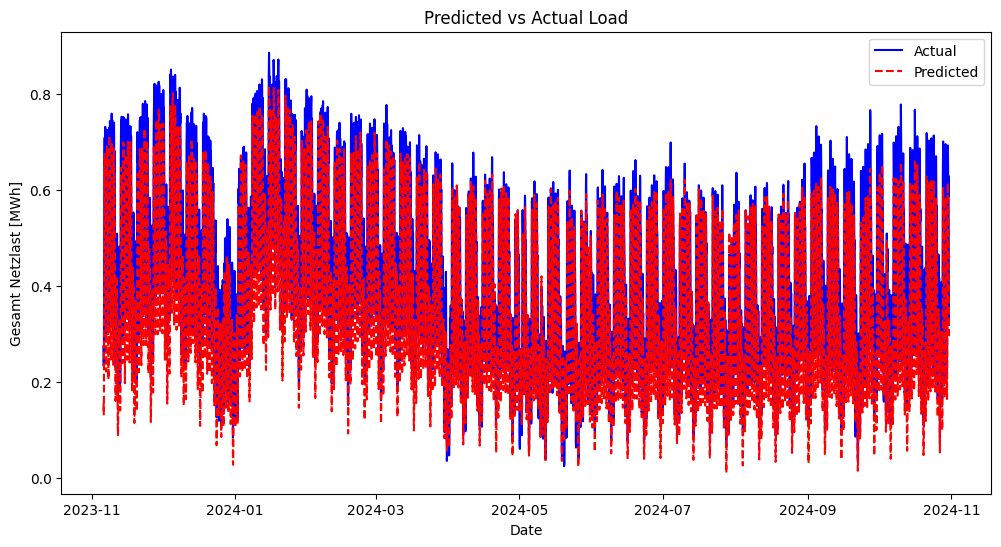

In [35]:
import matplotlib.pyplot as plt

# Convert to a DataFrame for plotting
pred_df = pd.DataFrame({'Date': test['Date'][window_size:].values, 'Actual': targets, 'Predicted': predictions})

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df['Date'], pred_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gesamt Netzlast [MWh]')
plt.title('Predicted vs Actual Load')
plt.legend()
plt.show()
